## Analysis of a ribosome profiling data using a transcriptome assembly as a reference

This analysis includes a highly phased ribosome profiling data for _Salmonella enterica_ serovar Typhimurium (PRJEB51486) and PacBio long-read and Illumina short-read data for transcriptome assembly (PRJEB6002)

### On a local machine to use Docker

#### 1. Download PacBio long-read RNA-seq data (strain D23005)

```
mkdir -p ~/Documents/manuscript/riboss ~/Documents/manuscript/riboss/styphimurium

cd ~/Documents/manuscript/riboss/styphimurium

wget "https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB6002&result=read_run&fields=study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,library_strategy,library_source,fastq_ftp,submitted_ftp,sra_ftp,sample_alias,sample_title,bam_ftp&format=tsv&download=true&limit=0" -O filereport_read_run_PRJEB6002_tsv.txt

awk 'BEGIN{FS="\t"} /m140726_040902|m140801_073558|m140814_095222/ {print $13}' \
    filereport_read_run_PRJEB6002_tsv.txt \
    | tr ';' '\n' \
    | awk '{print "wget -nc ftp://" $1}' | sh
```

#### 2. Download and run a Docker image for SMRT-analysis 2.3.0

```
sudo docker pull jyang88/smrtanalysis2.3.0:latest

sudo docker run -it -v /home/chunlim/Documents:/data jyang88/smrtanalysis2.3.0:latest bash

/opt/smrtanalysis/current/smrtcmds/bin/smrtshell

cd data/manuscript/riboss/styphimurium
```

#### 3. Create files of file names for SMRT-analysis

```
ls m140726_040902* > m140726_040902.fofn
ls m140801_073558* > m140801_073558.fofn
ls m140814_095222* > m140814_095222.fofn
```

#### 4. Construct CCS reads

```
for i in \*.fofn; do \
    ConsensusTools.sh CircularConsensus \
    --minFullPasses 0 --minPredictedAccuracy 75 \
    --parameters /opt/smrtanalysis/install/smrtanalysis_2.3.0.140936/analysis/etc/algorithm_parameters/2014-09/ \
    --numThreads 32 --fofn $i \
    -o output
done

cp output/*.fastq

gzip *.fastq
```

#### 5. Exit docker image and scp the the CCS fastq files to a server to continue the analysis

### On a server

#### 6. Download ribosome profiling and RNA-seq data (strain LT2)

```
mkdir -p /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq

cd /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq

wget "https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB51486&result=read_run&fields=study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,library_strategy,library_source,fastq_ftp,submitted_ftp,sra_ftp,sample_alias,sample_title,bam_ftp&format=tsv&download=true&limit=0" -O filereport_read_run_PRJEB51486_tsv.txt

awk 'BEGIN{FS="\t"} NR>1 {print "wget -nc ftp://" $12}' filereport_read_run_PRJEB51486_tsv.txt | sh
```

#### 7. Download Illumina short-read RNA-seq alignment files (strain D23005)

```
mkdir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/illumina

cd /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/illumina

awk 'BEGIN{FS="\t"} /14256_2#2|14256_2#8|14256_2#14|14256_2#5|14256_2#11|14256_2#17|13851_1#14|13851_1#13|13851_1#15/ {print $13}' \
    filereport_read_run_PRJEB6002_tsv.txt \
    | tr ';' '\n' \
    | awk '{print "wget -nc ftp://" $1}' | sh

#### 8. Install samtools (for handling CRAM quickly, [not](https://github.com/samtools/htslib/issues/605) a recommended installation method)

```
git clone https://github.com/samtools/samtools.git
cd samtools
SAMTOOLSDIR=$PWD
# git checkout eb0992ff8a99b895364a7a861b418a1beb77d540

wget https://github.com/samtools/htslib/releases/download/1.21/htslib-1.21.tar.bz2
tar jxvf htslib-1.21.tar.bz2
cd htslib-1.21
./configure --enable-libcurl --prefix=$PWD
make
cd ..

./configure --enable-plugins --enable-libcurl --with-htslib=$PWD/htslib-1.21
make all all-htslib
```

#### 9. Merge CRAM files

```
$SAMTOOLSDIR/samtools merge \
    14256_2\#2.cram 14256_2\#8.cram 14256_2\#14.cram \
    14256_2\#5.cram 14256_2\#11.cram 14256_2\#17.cram \
    13851_1\#14.cram 13851_1\#13.cram 13851_1\#15.cram \
    -o D23005.cram

samtools sort D23005.cram -O BAM -o ../D23005.sorted.bam

rm D23005.cram
```

#### 10. Download the LT2 reference genome for transcriptome_assembly

```
mkdir -p /home/limch05p/lim_group/riboss /home/limch05p/lim_group/riboss/ref

cd /home/limch05p/lim_group/riboss/ref

wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.1_ASM694v1/GCF_000006945.1_ASM694v1_genomic.fna.gz

zcat GCF_000006945.1_ASM694v1_genomic.fna.gz \
    | sed 's/NC_003197.1/gi|16763390|ref|NC_003197.1|/' \
    > NC_003197.1.fasta

wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.1_ASM694v1/GCF_000006945.1_ASM694v1_genomic.gff.gz

zcat GCF_000006945.1_ASM694v1_genomic.gff.gz \
    | gff3ToGenePred stdin stdout \
    | genePredToBed stdin stdout \
    | awk '/NC_003197.1/ && sub("NC_003197.1","gi|16763390|ref|NC_003197.1|")' \
    > NC_003197.1.bed
```

#### 11. Download and convert GFF3 to BED and GTF for operon_finder

```
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.2_ASM694v2/GCF_000006945.2_ASM694v2_genomic.gff.gz

zcat GCF_000006945.2_ASM694v2_genomic.gff.gz \
    | gff3ToGenePred stdin stdout \
    | genePredToBed stdin stdout \
    > NC_003197.2.bed

zcat GCF_000006945.2_ASM694v2_genomic.gff.gz \
    | gff3ToGenePred stdin stdout \
    | genePredToGtf file stdin stdout \
    > NC_003197.2.gtf
```

#### 12. Infer library type for short-read alignment

```
conda activate riboss
pip install rseqc
```

In [1]:
# https://www.biostars.org/p/295344/#295402
# So if 1++,1--,2+-,2-+" get more signal (Value) then its fr-secondstrand
# and if 1+-,1-+,2++,2-- get more signal (Value) then its fr-firststrand

! infer_experiment.py -i /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005.sorted.bam -r /home/limch05p/lim_group/riboss/ref/NC_003197.1.bed

Reading reference gene model /home/limch05p/lim_group/riboss/ref/NC_003197.1.bed ... Done
Loading SAM/BAM file ...  Total 200000 usable reads were sampled


This is PairEnd Data
Fraction of reads failed to determine: 0.0004
Fraction of reads explained by "1++,1--,2+-,2-+": 0.1697
Fraction of reads explained by "1+-,1-+,2++,2--": 0.8299


#### 13. Map PacBio long reads to genome and merge alignment files (strain D23005)

```
mkdir -p /home/limch05p/lim_group/riboss/doc \
    /home/limch05p/lim_group/riboss/doc/styphimurium \
    /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq \
    /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/pacbio

cd /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/pacbio

for i in _.gz; do \
    minimap2 -ax splice:hq -uf --sam-hit-only --MD \
    /home/limch05p/lim_group/riboss/ref/NC_003197.1.fasta \
    $i > ${i%%.*}.sam
done

samtools merge \
    m140726_040902_00127_c100661342550000001823130211271434_s1_p0.sam \
    m140801_073558_00127_c100661152550000001823130211271487_s1_p0.sam \
    m140814_095222_00127_c100669272550000001823130511271461_s1_p0.sam \
    -O BAM -o D23005-sc-1962750.bam

samtools sort D23005-sc-1962750.bam -O BAM -o ../D23005-sc-1962750.sorted.bam

rm D23005-sc-1962750.bam
```

#### 14. Assemble transcriptome by combining PacBio long-read and Illumina short-read RNA-seq data (strain D23005)

In [2]:
import os
from glob import glob
from riboss.wrapper import transcriptome_assembly

superkingdom = 'Bacteria'
genome = '/home/limch05p/lim_group/riboss/ref/NC_003197.1.fasta'
short_reads = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005.sorted.bam' 
long_reads = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.bam'
strandness = 'rf'

tx_assembly, gtf = transcriptome_assembly(superkingdom, genome, long_reads, short_reads, strandness)

INFO:root:saved StringTie GTF as /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.gtf
INFO:root:converted transcriptome assembly to /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.bed
INFO:root:extracted sequences to /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa


#### 15. Remap transcriptome assembly to newly assembled genome

```
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.2_ASM694v2/GCF_000006945.2_ASM694v2_genomic.fna.gz

# required for PyRanges
gunzip /home/limch05p/lim_group/riboss/ref/GCF_000006945.2_ASM694v2_genomic.fna.gz

minimap2 -ax splice:hq -uf --sam-hit-only --MD \
    /home/limch05p/lim_group/riboss/ref/GCF_000006945.2_ASM694v2_genomic.fna \
    /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa \
    | samtools view -b - \
    > /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bam

bedtools bamtobed -i \
    /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bam \
    > /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bed
```

In [3]:
import pandas as pd
import pyranges as pr

genome='/home/limch05p/lim_group/riboss/ref/GCF_000006945.2_ASM694v2_genomic.fna'
remap = pd.read_csv('/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bed', 
                    sep='\t', header=None)
# drop fragmented transcripts
remap['STRG'] = remap[3].str.split('::').str[0]
remap.drop_duplicates('STRG', keep=False, inplace=True)

remap['tid'] = '>' + remap['STRG'] + '::' + remap[0] + ':' + remap[1].astype(str) + '-' + remap[2].astype(str) + '(' + remap[5] + ')'
remap = remap[[0,1,2,'tid',5]]
remap.columns = ['Chromosome','Start','End','tid','Strand']
remap = pr.PyRanges(remap)
remap.dna = pr.get_sequence(remap, genome)
remap.df[['tid','dna']].to_csv('/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.fa',
                               sep='\n', index=None, header=None)

#### Build STAR index for the newly assembled transcriptome

In [4]:
from riboss.wrapper import build_star_index

tx_assembly = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
index = tx_assembly.split(os.extsep)[0]

build_star_index(tx_assembly, index)

	STAR --runMode genomeGenerate --runThreadN 4 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --genomeFastaFiles /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.fa --genomeSAindexNbases 7 --genomeChrBinNbits 11
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 14 10:41:27 ..... started STAR run
Oct 14 10:41:28 ... starting to generate Genome files
Oct 14 10:41:29 ... starting to sort Suffix Array. This may take a long time...
Oct 14 10:41:29 ... sorting Suffix Array chunks and saving them to disk...
Oct 14 10:41:30 ... loading chunks from disk, packing SA...
Oct 14 10:41:30 ... finished generating suffix array
Oct 14 10:41:30 ... generating Suffix Array index
Oct 14 10:41:30 ... completed Suffix Array index
Oct 14 10:41:31 ... writing Genome to disk ...
Oct 14 10:41:31 ... writing Suffix Array to disk ...
Oct 14 10:41:31 ... writing SAindex to disk
Oct 14 10

INFO:root:saved index to /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750


#### Map ribosome footprints to transcriptome

In [5]:
from riboss.wrapper import align_short_reads

for i in glob('/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/*[0-9].fastq.gz'):
    prefix = i.split(os.extsep)[0]    
    align_short_reads(i, prefix, index)

	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 14 10:41:32 ..... started STAR run
Oct 14 10:41:35 ..... loading genome
Oct 14 10:41:35 ..... started mapping
Oct 14 10:47:36 ..... finished mapping
Oct 14 10:47:36 ..... finished successfully


INFO:root:saved alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946Aligned.out.bam


	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130943.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130943 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 14 10:47:37 ..... started STAR run
Oct 14 10:47:37 ..... loading genome
Oct 14 10:47:38 ..... started mapping
Oct 14 10:51:48 ..... finished mapping
Oct 14 10:51:49 ..... finished successfully


INFO:root:saved alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130943Aligned.out.bam


	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130945.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130945 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 14 10:51:49 ..... started STAR run
Oct 14 10:51:50 ..... loading genome
Oct 14 10:51:50 ..... started mapping
Oct 14 10:53:48 ..... finished mapping
Oct 14 10:53:49 ..... finished successfully


INFO:root:saved alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130945Aligned.out.bam


	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130944.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130944 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 14 10:53:49 ..... started STAR run
Oct 14 10:53:49 ..... loading genome
Oct 14 10:53:50 ..... started mapping
Oct 14 10:56:19 ..... finished mapping
Oct 14 10:56:19 ..... finished successfully


INFO:root:saved alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130944Aligned.out.bam


	STAR --runMode alignReads --readFilesIn /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942.fastq.gz --outFileNamePrefix /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942 --genomeDir /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Oct 14 10:56:19 ..... started STAR run
Oct 14 10:56:20 ..... loading genome
Oct 14 10:56:20 ..... started mapping


INFO:root:saved alignment to/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942Aligned.out.bam


Oct 14 10:58:04 ..... finished mapping
Oct 14 10:58:04 ..... finished successfully


#### Predict operons from transcriptome assembly

finding all ORFs       : 100%|██████████████████| 256/256 [00:01<00:00, 177it/s]
INFO:root:plotted the distribution of operons as /home/limch05p/lim_group/riboss/results/operon_finder/D23005-sc-1962750.operon_dist.pdf and/home/limch05p/lim_group/riboss/results/operon_finder/D23005-sc-1962750.operon_scatter.pdf
INFO:root:saved operons and ORFs as /home/limch05p/lim_group/riboss/results/operon_finder/D23005-sc-1962750.operon_finder.pkl.gz
INFO:root:saved CDS range as /home/limch05p/lim_group/riboss/results/operon_finder/D23005-sc-1962750.cds_range.txt


ORF_type
oORF    30965
sORF    28391
mORF      899
Name: count, dtype: int64

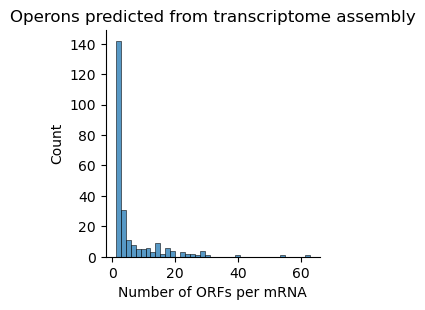

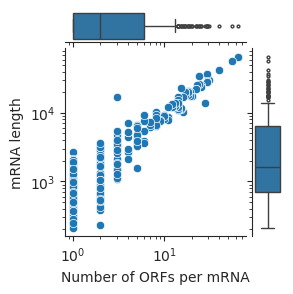

In [1]:
from riboss.orfs import operon_finder
import pyranges as pr
import pandas as pd

bed = '/home/limch05p/lim_group/riboss/ref/NC_003197.2.bed'
outdir = '/home/limch05p/lim_group/riboss/results/operon_finder'
tx_assembly = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
delim = '::'

cds_range, df = operon_finder(tx_assembly, bed, outdir, delim)
df.value_counts('ORF_type')

#### Analyse ribosome footprints

downsampling BAM       : 4944612it [00:07, 650453.77it/s]
comparing periodicity  : 100%|███████████████| 11.0/11.0 [00:02<00:00, 3.72it/s]
INFO:root:saved selected footprint sizes with an offset as /home/limch05p/lim_group/riboss/results/analyse_footprints/ERR9130942Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as /home/limch05p/lim_group/riboss/results/analyse_footprints/ERR9130942Aligned.out.frames.pdf
INFO:root:saved metagene plots as /home/limch05p/lim_group/riboss/results/analyse_footprints/ERR9130942Aligned.out.start_codon.pdf and /home/limch05p/lim_group/riboss/results/analyse_footprints/ERR9130942Aligned.out.stop_codon.pdf
downsampling BAM       : 12595789it [00:18, 674418.13it/s]
comparing periodicity  : 100%|███████████████| 11.0/11.0 [00:07<00:00, 1.49it/s]
INFO:root:saved selected footprint sizes with an offset as /home/limch05p/lim_group/riboss/results/analyse_footprints/ERR9130943Aligned.out.offset.txt
INFO:root:converted mapped frames into heatma

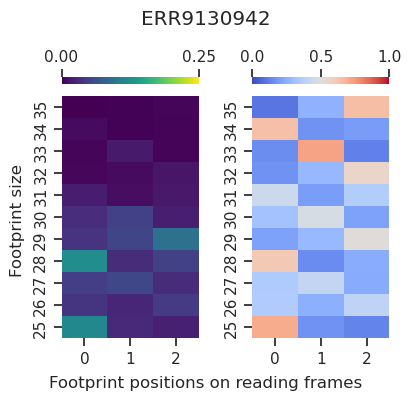

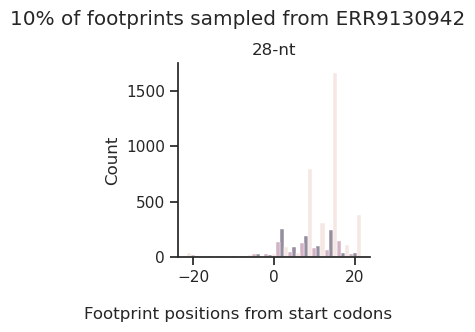

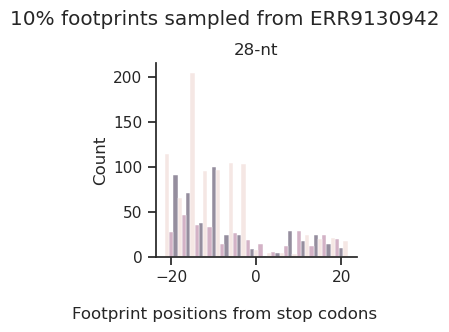

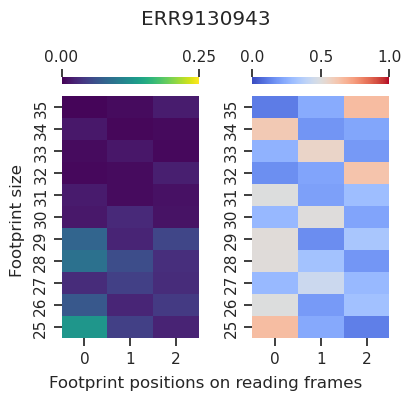

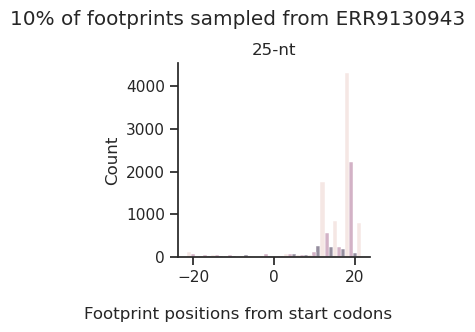

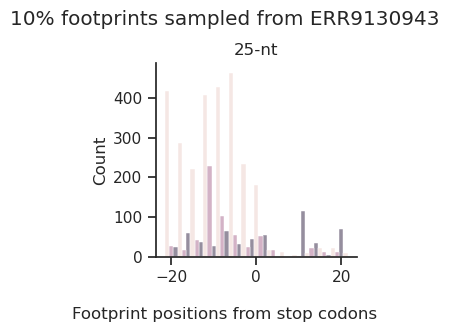

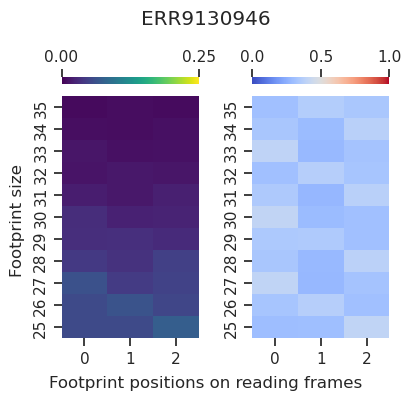

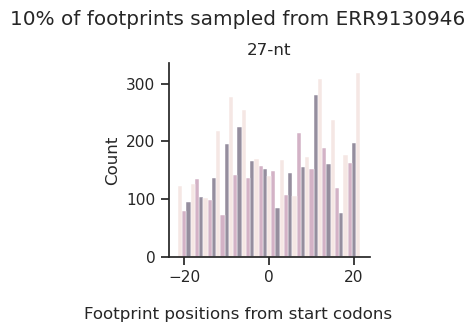

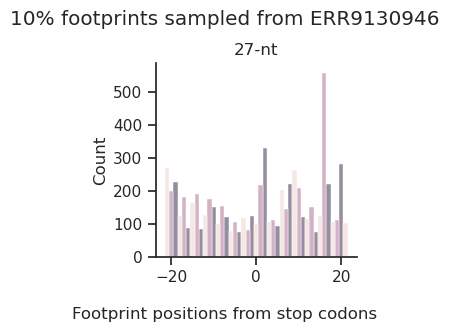

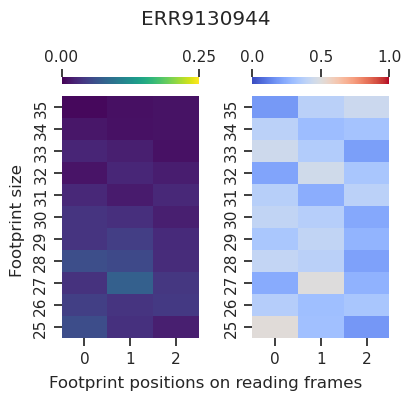

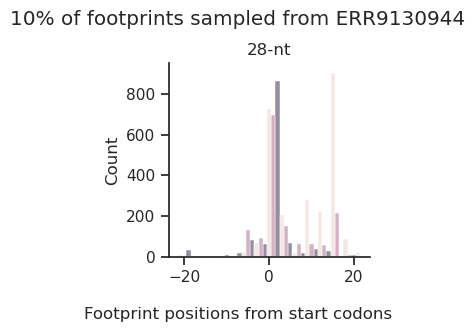

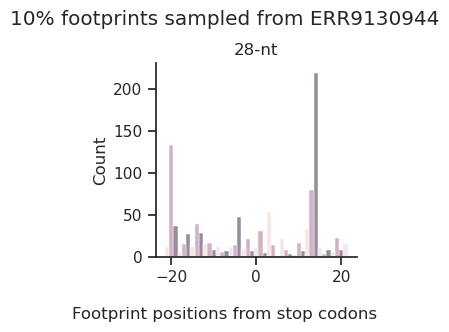

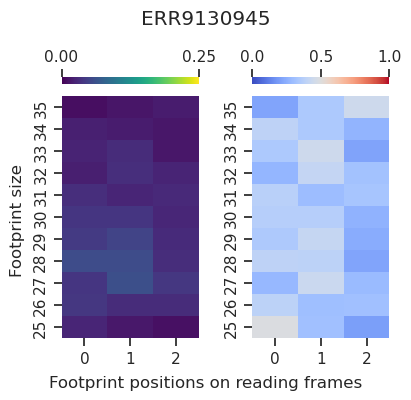

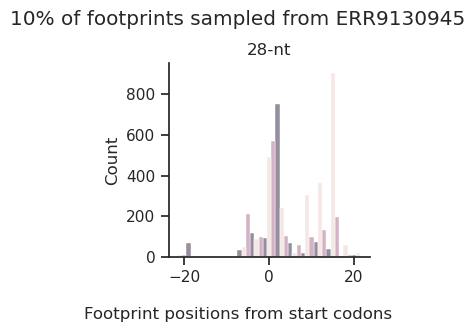

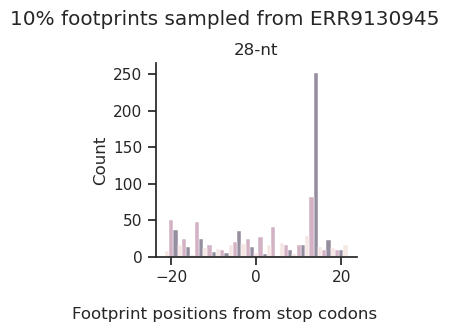

In [2]:
from riboss.footprints import analyse_footprints
from glob import glob
downsampling = 0.1

outdir = '/home/limch05p/lim_group/riboss/results/analyse_footprints'

footprint_stats = []
for i in glob('/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/*Aligned.out.bam'):
    stats = analyse_footprints('Bacteria', i, downsampling, cds_range, 'best', outdir)
    footprint_stats.append(stats)

In [3]:
import pandas as pd

filereport = pd.read_csv('/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/filereport_read_run_PRJEB51486_tsv.txt', sep='\t')
filereport[['run_accession','sample_title']]

,run_accession,sample_title
0,ERR9130944,RiboSeq S7 1000U
1,ERR9130945,RiboSeq S7 750U
2,ERR9130942,RiboSeq RNase1 1000U
3,ERR9130943,RiboSeq RNase1 500U
4,ERR9130946,RNA-Seq


#### Merge ribosome profiling data and footprint offset files

In [4]:
! samtools merge /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942Aligned.out.bam \
    /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130943Aligned.out.bam \
    -f -o /home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942_3.bam

! cat /home/limch05p/lim_group/riboss/results/analyse_footprints/ERR9130943Aligned.out.offset.txt \
    /home/limch05p/lim_group/riboss/results/analyse_footprints/ERR9130942Aligned.out.offset.txt > \
    /home/limch05p/lim_group/riboss/results/analyse_footprints/offset.txt

#### Build salmon index using transcriptome assembly and run salmon quant

In [5]:
from riboss.wrapper import count_reads

index = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750'
tx_assembly = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
rnaseq = '/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946.trimmed.fastq.gz'

count_reads(rnaseq, tx_assembly, index)

Version Info: This is the most recent version of salmon.
index ["/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750_puff"] did not previously exist  . . . creating it
[2024-10-14 20:21:01.595] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2024-10-14 20:21:01.595] [jLog] [info] building index
out : /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750_puff
[2024-10-14 20:21:01.597] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2024-10-14 20:21:01.637] [puff::index::jointLog] [info] Replaced 0 non-ATCG nucleotides
[2024-10-14 20:21:01.637] [puff::index::jointLog] [info] Clipped poly-A tails from 0 transcr

Threads = 2
Vertex length = 31
Hash functions = 5
Filter size = 33554432
Capacity = 2
Files: 
/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750_puff/ref_k31_fixed.fa
--------------------------------------------------------------------------------
Round 0, 0:33554432
Pass	Filling	Filtering
1	0	0	
2	0	0
True junctions count = 119
False junctions count = 2607
Hash table size = 2726
Candidate marks count = 2892
--------------------------------------------------------------------------------
Reallocating bifurcations time: 0
True marks count: 770
Edges construction time: 0
--------------------------------------------------------------------------------
Distinct junctions = 119



TwoPaCo::buildGraphMain:: allocated with scalable_malloc; freeing.
TwoPaCo::buildGraphMain:: Calling scalable_allocation_command(TBBMALLOC_CLEAN_ALL_BUFFERS, 0);
allowedIn: 42
Max Junction ID: 658
seen.size():5273 kmerInfo.size():659
approximateContigTotalLength: 1287910
counters for complex kmers:
(prec>1 & succ>1)=14 | (succ>1 & isStart)=0 | (prec>1 & isEnd)=1 | (isStart & isEnd)=0
contig count: 435 element count: 1409613 complex nodes: 15
# of ones in rank vector: 434
[2024-10-14 20:21:02.070] [puff::index::jointLog] [info] Starting the Pufferfish indexing by reading the GFA binary file.
[2024-10-14 20:21:02.070] [puff::index::jointLog] [info] Setting the index/BinaryGfa directory /home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750_puff
size = 1409613
-----------------------------------------
| Loading contigs | Time = 1.1587 ms
-----------------------------------------
size = 1409613
-----------------------------------------
| Loading contig boundaries | Time 

for info, total work write each  : 2.331    total work inram from level 3 : 4.322  total work raw : 25.000 
Bitarray         7323648  bits (100.00 %)   (array + ranks )
final hash             0  bits (0.00 %) (nb in final hash 0)


-----------------------------------------
| Loading contig table | Time = 874.09 us
-----------------------------------------
size = 435
-----------------------------------------
| Loading contig offsets | Time = 1.1004 ms
-----------------------------------------
-----------------------------------------
| Loading reference lengths | Time = 3.356 us
-----------------------------------------
-----------------------------------------
| Loading mphf table | Time = 970.84 us
-----------------------------------------
size = 1409613
Number of ones: 434
Number of ones per inventory item: 512
Inventory entries filled: 1
-----------------------------------------
| Loading contig boundaries | Time = 3.2737 ms
-----------------------------------------
size = 1409613
-----------------------------------------
| Loading sequence | Time = 966.86 us
-----------------------------------------
size = 1396593
-----------------------------------------
| Loading positions | Time = 8.4042 ms
---------------

#### Run riboprof (ribomap)

In [1]:
from riboss.wrapper import riboprofiler

offset = '/home/limch05p/lim_group/riboss/results/analyse_footprints/offset.txt'
ribobam = '/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130942_3.bam'
mrnabam = '/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946Aligned.out.bam'
tx_assembly = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
sf = '/home/limch05p/lim_group/riboss/doc/styphimurium/riboseq/ERR9130946_salmon_quant/quant.sf'
out = '/home/limch05p/lim_group/riboss/results/riboprofiler/ERR9130942_3'
cds_range_file = '/home/limch05p/lim_group/riboss/results/D23005-sc-1962750.cds_range.txt'

riboprof_base = riboprofiler(offset, ribobam, mrnabam, 
                             tx_assembly, cds_range_file, 
                             sf, out)

getting transcript info...
total number of transcripts in transcriptome: 256
assigning ribo-seq reads...
constructing profile class...
number of transcripts in profile class: 253
loading reads from bam...
getting readlen mapping to P site offset...
getting alignment records...
total number of reads: 12717796
getting read type and p-sites...
total output footprint: 12717796
total: 12717796 multi_mapped: 101467 (0.80 %)
assigning reads to frame 0 loci...
reads used: 1490964 reads assigned: 1490964
total input count not matching total assigning count!
assigning reads to frame 1 and 2 loci...
reads used: 4078426 reads assigned: 4078426
assigning reads to UTR loci...
reads used: 4078426 reads assigned: 4078426
assigning RNA-seq reads...
number of transcripts in profile class: 253
loading reads from bam...
getting alignment records...
total number of reads: 12355291
getting read type and p-sites...
total output footprint: 12355291
total: 12355291 multi_mapped: 265215 (2.15 %)
assigning reads

INFO:root:saved main output as /home/limch05p/lim_group/riboss/results/riboprofiler/ERR9130942_3.base


#### Find new ORFs using the main RIBOSS function

parsing ribomap output : 100%|████████████████| 249/249 [00:00<00:00, 2.26kit/s]
counting footprints    : 100%|█████████████| 60.1k/60.1k [00:00<00:00, 115kit/s]
comparing periodicity  : 100%|█████████████| 9.78k/9.78k [23:55<00:00, 6.81it/s]
INFO:root:saved RIBOSS stats as /home/limch05p/lim_group/riboss/results/riboss/ERR9130942_3.riboss.csv and /home/limch05p/lim_group/riboss/results/riboss/ERR9130942_3.riboss.json
INFO:root:saved significant RIBOSS results (n=282) as /home/limch05p/lim_group/riboss/results/riboss/ERR9130942_3.riboss.sig.csv, /home/limch05p/lim_group/riboss/results/riboss/ERR9130942_3.riboss.sig.json, and /home/limch05p/lim_group/riboss/results/riboss/ERR9130942_3.riboss.sig.bed
INFO:root:perform BLASTP for RIBOSS hits (n=282)
INFO:root:finished BLASTP in 2 min 4 s
INFO:root:saved BLASTP results for RIBOSS hits as /home/limch05p/lim_group/riboss/results/riboss/ERR9130942_3.riboss.sig.blastp.xml
INFO:root:efetch IPG for 160 accession numbers
INFO:root:finished efetch

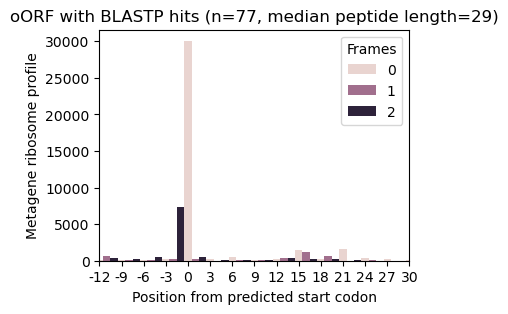

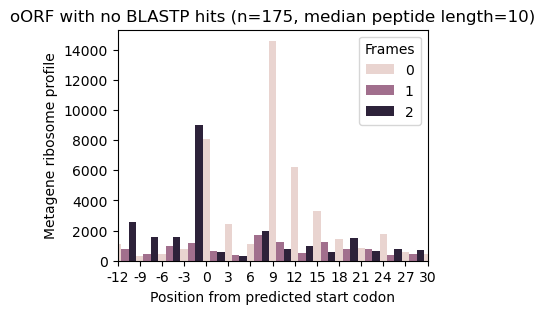

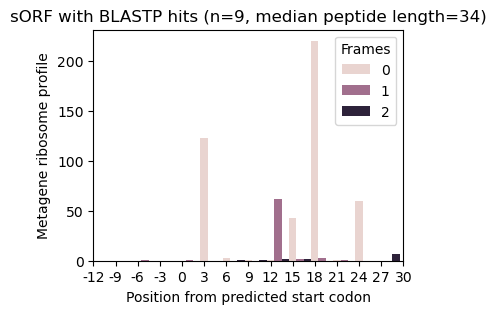

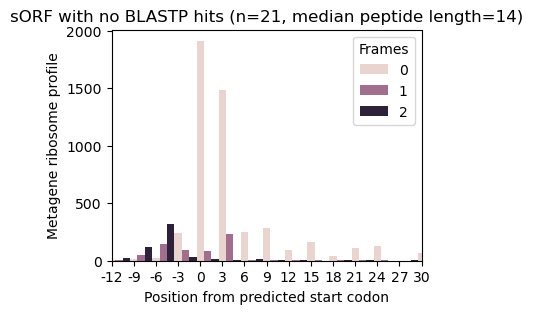

In [1]:
from riboss.riboss import riboss
import pandas as pd

riboprof_base = '/home/limch05p/lim_group/riboss/results/riboprofiler/ERR9130942_3.base'
tx_assembly = '/home/limch05p/lim_group/riboss/doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
superkingdom='Bacteria'
df = pd.read_pickle('/home/limch05p/lim_group/riboss/results/operon_finder/D23005-sc-1962750.operon_finder.pkl.gz')
outdir = '/home/limch05p/lim_group/riboss/results/riboss'
email='chunshen.lim@otago.ac.nz'
api_key='55890b8dfafe4d49e57c5f1d031aec4c2509'

ipg, tophits, blast, sig, boss_df = riboss(superkingdom, df, riboprof_base, tx_assembly,
                                           tie=False, num_simulations=1000, 
                                           run_blastp=True, run_efetch=True, tries=5, sleep=1, 
                                           email=email, api_key=api_key, delim='::',
                                           outdir=outdir)

In [2]:
tophits.dropna().title.str.split(r'\| ').str[1].str.split(r' \[').str[0].unique()

array(['undecaprenyl-phosphate galactose phosphotransferase WbaP',
       'transposase, partial', 'hypothetical protein, partial',
       'DNA mismatch repair protein MutS', 'acyl carrier protein',
       'hypothetical protein', 'metallophosphoesterase',
       'aldehyde dehydrogenase family protein',
       'MULTISPECIES: leader peptide SpeFL',
       'toxin glutamine deamidase domain-containing protein',
       'exoribonuclease R', 'hypothetical protein SEEH2823_19381',
       'transcriptional regulator MalT',
       'HTH-type transcriptional regulator MalT',
       'Ornithine decarboxylase, inducible', 'reductase',
       'amino acid permease', 'ketol-acid reductoisomerase',
       'needle length control protein',
       'phosphotransferase enzyme II, C component',
       'FtsW/RodA/SpoVE family cell cycle protein',
       'UDP-N-acetyl-D-mannosamine dehydrogenase',
       'hypothetical protein DMB90_20455',
       'hypothetical protein MYA98_16590',
       'SH3 domain-containing pr